In [ ]:
import pandas as pd
import json
import numpy as np
import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=dfea2d04c06f89fef38191c30518b3694629536cc5bfb6ba2baeefeb8d97672d
  Stored in directory: /root/.cache/pip/wheels/51/92/44/e2ef13f803aa08711819357e6de0c5fe67b874671141413565
Successfully built emoji


In [ ]:
import string
from string import punctuation
import emoji
import re
import nltk
from spacy.lang.it.stop_words import STOP_WORDS as it_stop

In [ ]:
#read dataset from tsv to pandas df
df_train = pd.read_csv('/content/drive/MyDrive/train_a.tsv',sep = '\t')
df_dev = pd.read_csv('/content/drive/MyDrive/geolingit-data/standard-track/subtask_a/dev_a.tsv',sep = '\t')
#
df_test = pd.read_csv('/content/drive/MyDrive/geolingit-data/test_a.tsv',sep = '\t')

In [ ]:
df_train

id                                               text     region
0          1  Non ho capito se i boni indossano le birkensto...     Marche
1          2  [USER] Ma quale mafia dice il saggio a napoli ...   Campania
2          3  in risposta ad un cazzaro virtussino, il quale...  Lombardia
3          4  POI SE BU AVANZANU ZEPPULE PASSATI DE CASA CA ...   Calabria
4          5  [USER] Come disse n’amica mia anni fa, alla se...      Lazio
...      ...                                                ...        ...
13664  13665  [USER] [USER] Te sei uno de quelli che buttiam...      Lazio
13665  13666  “Sai come si chiama il #blackfriday senza il G...     Veneto
13666  13667  Carramba! ho scoperto che la figlia di mia cug...      Lazio
13667  13668  Quando sprechi una #polaroid  per fare una fot...    Toscana
13668  13669  [USER] Tu puoi avere solo la fogna come fonte,...   Campania

[13669 rows x 3 columns]

In [ ]:
df_train.value_counts('region')

In [ ]:
df_train.groupby('region').count()['text']

region
Abruzzo                   150
Basilicata                 49
Calabria                  280
Campania                 2971
Emilia Romagna            315
Friuli-Venezia Giulia     216
Lazio                    5549
Liguria                   222
Lombardia                 686
Marche                    181
Molise                     35
Piemonte                  234
Puglia                    265
Sardegna                  359
Sicilia                   608
Toscana                   418
Trentino-Alto Adige        52
Umbria                    135
Valle d'Aosta              14
Veneto                    761
Name: text, dtype: int64

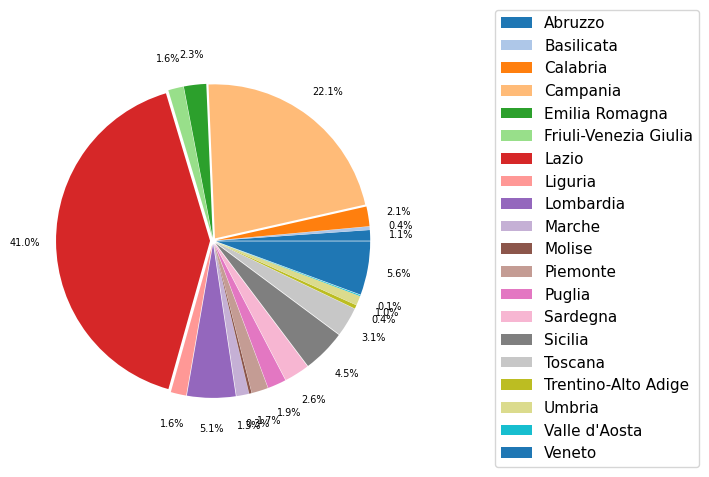

In [ ]:
counts = df_train.groupby('region').count()['text']

labels = sorted(df_train['region'].unique())
#define Seaborn color palette to use
colors = sns.color_palette('tab20')[0:19]

plt.figure(figsize=(5,5))
pie = plt.pie(counts, labels = None, colors= colors, textprops={'fontsize': 7}, autopct='%1.1f%%', pctdistance=1.2, explode=[0.02]*20)
plt.legend(pie[0],labels, bbox_to_anchor=(1.5,0.5), loc="right", fontsize=11, bbox_transform=plt.gcf().transFigure)
plt.savefig('cake_train_labels.png', bbox_inches='tight')
plt.show()

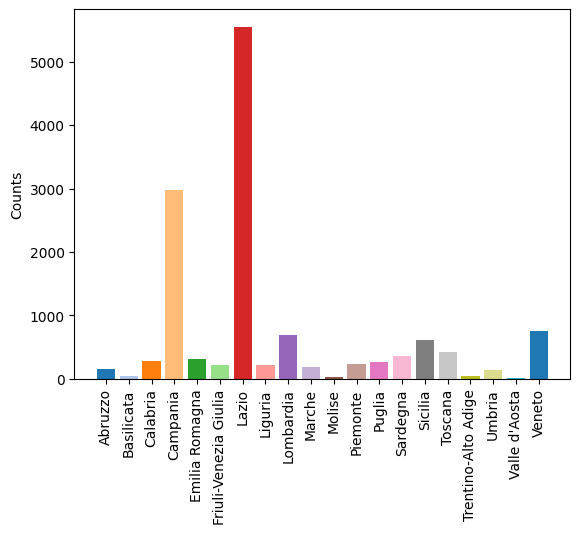

In [ ]:
bars = plt.bar(labels, counts, width=0.8, color = colors)
plt.ylabel("Counts")
plt.xticks(rotation='vertical')
plt.show()

nessun dato mancate o incompleto

In [ ]:
print(df_train.isnull().sum())
print("\n")
print(df_dev.groupby('region').count()['text'])

id        0
text      0
region    0
dtype: int64


region
Calabria                  27
Campania                  85
Emilia Romagna            30
Friuli-Venezia Giulia     25
Lazio                    115
Liguria                   25
Lombardia                 43
Piemonte                  25
Puglia                    27
Sardegna                  31
Sicilia                   40
Toscana                   34
Veneto                    45
Name: text, dtype: int64


NEL DEV SET CI SONO SOLO LE REGIONI DA UTILIZZARE PER IL TASK :
13 REGIONI

In [ ]:
DEV_REGIONS = sorted(df_dev['region'].unique())

In [ ]:
df_train[df_train.duplicated(['text'])]

id                                               text     region
6308    6309                              [USER] Chi lu le semo  Lombardia
7186    7187                                   [USER] T'è vist?     Veneto
7218    7219                                 [USER] Stann accis   Campania
8028    8029                                 [USER] Stann accis   Campania
8989    8990  Nttld (Lassa pur ch'el mond el disa) @ [LOCATI...  Lombardia
9908    9909                                          Ghe sboro     Veneto
10051  10052                           [USER] [USER] Datte foco      Lazio
10988  10989                              [USER] Chi lu le semo   Piemonte
11261  11262                                 [USER] Dicce dicce      Lazio
12234  12235                          [USER] Ma quant si strunz   Campania

ci sono duplicati che possono assumere una classificazione diversa in base a determinate parole di dialetti micro-regionali.
Elimino solo i duplicati che hanno stessa classificazione e stesso testo

In [ ]:
df_train[df_train['text'].str.contains('Chi lu le semo')]

id                          text     region
3008    3009  [USER] [USER] Chi lu le semo  Lombardia
3632    3633         [USER] Chi lu le semo  Lombardia
6308    6309         [USER] Chi lu le semo  Lombardia
10988  10989         [USER] Chi lu le semo   Piemonte

In [ ]:
df_train.drop_duplicates(subset ='text',keep = "first", inplace = True)
print(df_train.shape)

(13659, 3)


In [ ]:
df_train[df_train['text'].str.contains('Chi lu le semo')]

id                          text     region
3008  3009  [USER] [USER] Chi lu le semo  Lombardia
3632  3633         [USER] Chi lu le semo  Lombardia

In [ ]:
df_train[df_train['text'].str.contains('Dicce dicce')]

id                                               text region
229      230                   [USER] [USER] [USER] Dicce dicce  Lazio
2968    2969                                 [USER] Dicce dicce  Lazio
4303    4304  [USER] [USER] Perché hai fatto la.foto al coll...  Lazio
5077    5078                          [USER] [USER] Dicce dicce  Lazio
10877  10878  [USER] [USER] Perchè catfight? Sarebbe solo bo...  Lazio
11333  11334  [USER] [USER] [USER] [USER] [USER] [USER] [USE...  Lazio
11996  11997                                  Dicce dicce [URL]  Lazio

In [ ]:
df_train[df_train['text'].str.contains('Nttld')]

id                                               text     region
2068  2069  Nttld (Lassa pur ch'el mond el disa) @ [LOCATI...  Lombardia

In [ ]:
print(df_train[df_train['text'].str.contains("T'è vist?")])
print(df_train[df_train['text'].str.contains('Stann accis')])
print(df_train[df_train['text'].str.contains('Datte foco')])
print(df_train[df_train['text'].str.contains('Ghe sboro')])

          id                     text     region
6255    6256         [USER] T'è vist?  Lombardia
13287  13288  [USER] T'è vist... 😂😂😂😂  Lombardia
          id                                               text    region
3820    3821  [USER] [USER] [USER] Ma giauno che scrive una ...  Campania
5575    5576                          [USER] [USER] Stann accis  Campania
6899    6900                                 [USER] Stann accis  Campania
11626  11627  [USER] Non ho il piacere... 😂 😂 😂 😂 Stann acci...  Campania
        id                      text   region
9492  9493  [USER] [USER] Datte foco  Toscana
          id                                               text  region
3368    3369  [USER] Ghe sboro more ieri ho bevuto solo un d...  Veneto
3449    3450  [USER] Ghe sboro vecio tra tante cose che ti e...  Veneto
3541    3542                                          Ghe sboro  Veneto
3766    3767                        Ghe sboro però che afa oggi  Veneto
4814    4815  [USER] Ghe sboro 

In [ ]:
#drop specific tweet
df_train.drop([2968,3632,5077,6899,11996,13287], inplace=True)
print(df_train.shape)

(13653, 3)


CLEANING PRE PROCESSING

In [ ]:
#preprocessing e cleaning text - CLEANING STANDARD
def cleaner(tweet):
    print(tweet)
    ctweet = tweet
    ctweet = ctweet.translate(string.punctuation) #remove punctuation
    ctweet = ctweet.lower().split() # to lowercase and split
    ctweet = " ".join(ctweet)
    ctweet = re.sub(r"@[^A-Za-z0-9^,!.\/'+-=]+", " ", ctweet) #Remove sign special
    ctweet = re.sub("#[A-Za-z0-9_]+", " ", ctweet)
    ctweet = re.sub(r"[.?!]*(?=[.?!]$)", " ", ctweet)
    ctweet = re.sub(f"[{re.escape(punctuation)}]", " ", ctweet) #remove punctuaction
    ctweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", " ", ctweet) #remove http links
    ctweet = re.sub(r'(.)\1{2,}',r'\1', ctweet) #remove repetead caracter
    ctweet = re.sub(r"\b[0-9]+\b\s*", " ", ctweet) #remove numbers
    ctweet = re.sub("\S*\d\S*", " ", ctweet).strip() #remove words with numbers
    ctweet = re.sub(r"“", " ", ctweet)
    ctweet = re.sub(r"”", " ", ctweet)
    ctweet = re.sub(r"‘", " ", ctweet)
    ctweet = re.sub(r"’", " ", ctweet)
    ctweet = re.sub(r"′", " ", ctweet)
    ctweet = re.sub(r"…", " ", ctweet)
    ctweet = re.sub(r"«", " ", ctweet)
    ctweet = re.sub(r"»", " ", ctweet)
    ctweet = re.sub(r"x", " ", ctweet)
    ctweet = re.sub(r"xe", " ", ctweet)
    ctweet = re.sub(r"xo", " ", ctweet)
    ctweet = re.sub(r"xd", " ", ctweet)
    ctweet = re.sub(r"user", " ", ctweet)
    ctweet = re.sub(r"url", " ", ctweet)
    #remove some specific chars of dataset
    ctweet = re.sub(r"•", " ", ctweet)
    ctweet = re.sub(r"°", " ", ctweet)
    ctweet = re.sub(r"▪", " ", ctweet)
    ctweet = re.sub(r"€¥¢¿¶§×", " ", ctweet)
    ctweet = re.sub(r"porc ¥¢ ¶§×", " ", ctweet)
    ctweet = re.sub(r"€", " ", ctweet)
    ctweet = re.sub(r"¿", " ", ctweet)
    ctweet = re.sub(r"°c", " ", ctweet)
    ctweet = re.sub(r"三国", " ", ctweet)
    ctweet = re.sub(r"ĺ", "l", ctweet)
    ctweet = re.sub(r"aa", "a", ctweet)
    ctweet = re.sub(r"æ", "a", ctweet)
    ctweet = re.sub(r"ıbrıszaferedoğru", " ", ctweet)
    ctweet = re.sub(r"pepepepepepepepepepepe", " ", ctweet)
    ctweet = re.sub(r"ècallejon", " ", ctweet)
    ctweet = re.sub(r"çayoğlu", " ", ctweet)
    ctweet = re.sub(r"çalkapımı", " ", ctweet)
    ctweet = re.sub(r"çajuve", " ", ctweet)
    ctweet = re.sub(r'\b(a*ha+h[ha]*|o?l+o+l+[ol]*)\b', " ", ctweet) #remove some laugh exclamation
    ctweet = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",ctweet) if s]) #split attached words
    ctweet = " ".join(ctweet.split()) #remove extra space
    words = ctweet.split()
    ctweet =" ".join(sorted(set(words), key=words.index)) #remove repeated words
    ctweet = emoji.replace_emoji(ctweet, replace=' ')
    ctweet = ctweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    #remove italian stop words
    #sw = set(stopwords.words("italian"))
    words = ctweet.split()
    clean_words = [w for w in words if not w in it_stop] #remove italian stop words
    ctweet = " ".join(clean_words)
    print(ctweet)
    print("\n")
    return ctweet

In [ ]:
#preprocessing e cleaning text  - CLEANING WITHOUT APOSTROFI
def cleaner_2(tweet):
    print(tweet)
    ctweet = tweet

    my_punctuation = punctuation.replace("'", "")
    ctweet = ctweet.translate(string.punctuation) #remove punctuation
    ctweet = ctweet.lower().split() # to lowercase and split
    ctweet = " ".join(ctweet)
    ctweet = re.sub(r"@[^A-Za-z0-9^,!.\/'+-=]+", " ", ctweet) #Remove sign special
    ctweet = re.sub("#[A-Za-z0-9_]+", " ", ctweet)
    ctweet = re.sub(r"[.?!]*(?=[.?!]$)", " ", ctweet)
    ctweet = re.sub(f"[{re.escape(my_punctuation)}]", " ", ctweet) #remove punctuaction
    ctweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", " ", ctweet) #remove http links
    ctweet = re.sub(r'(.)\1{2,}',r'\1', ctweet) #remove repetead caracter
    ctweet = re.sub(r"\b[0-9]+\b\s*", " ", ctweet) #remove numbers
    ctweet = re.sub("\S*\d\S*", " ", ctweet).strip() #remove words with numbers
    #ctweet = re.sub(r"“", " ", ctweet)
    #ctweet = re.sub(r"”", " ", ctweet)
    #ctweet = re.sub(r"‘", " ", ctweet)
    #ctweet = re.sub(r"’", " ", ctweet)
    #ctweet = re.sub(r"′", " ", ctweet)
    ctweet = re.sub(r"…", " ", ctweet)
    ctweet = re.sub(r"«", " ", ctweet)
    ctweet = re.sub(r"»", " ", ctweet)
    ctweet = re.sub(r"x", " ", ctweet)
    ctweet = re.sub(r"xe", " ", ctweet)
    ctweet = re.sub(r"xo", " ", ctweet)
    ctweet = re.sub(r"xd", " ", ctweet)
    ctweet = re.sub(r"user", " ", ctweet)
    ctweet = re.sub(r"url", " ", ctweet)
    #remove some specific chars of dataset
    ctweet = re.sub(r"°", " ", ctweet)
    ctweet = re.sub(r"•", " ", ctweet)
    ctweet = re.sub(r"▪", " ", ctweet)
    ctweet = re.sub(r"€¥¢¿¶§×", " ", ctweet)
    ctweet = re.sub(r"porc ¥¢ ¶§×", " ", ctweet)
    ctweet = re.sub(r"€", " ", ctweet)
    ctweet = re.sub(r"¿", " ", ctweet)
    ctweet = re.sub(r"°c", " ", ctweet)
    ctweet = re.sub (r"三国", " ", ctweet)
    ctweet = re.sub (r"ĺ", "l", ctweet)
    ctweet = re.sub(r"aa", "a", ctweet)
    ctweet = re.sub(r"æ", "a", ctweet)
    ctweet = re.sub (r"ıbrıszaferedoğru", " ", ctweet)
    ctweet = re.sub(r"pepepepepepepepepepepe", " ", ctweet)
    ctweet = re.sub (r"ècallejon", " ", ctweet)
    ctweet = re.sub (r"çayoğlu", " ", ctweet)
    ctweet = re.sub (r"çalkapımı", " ", ctweet)
    ctweet = re.sub (r"çajuve", " ", ctweet)
    ctweet = re.sub(r'\b(a*ha+h[ha]*|o?l+o+l+[ol]*)\b', " ", ctweet) #remove some laugh exclamation
    ctweet = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",ctweet) if s]) #split attached words
    ctweet = " ".join(ctweet.split()) #remove extra space
    words = ctweet.split()
    ctweet =" ".join(sorted(set(words), key=words.index)) #remove repeated words
    ctweet = emoji.replace_emoji(ctweet, replace=' ')
    ctweet = ctweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    #remove italian stop words
    #sw = set(stopwords.words("italian"))
    words = ctweet.split()
    clean_words = [w for w in words if not w in it_stop] #it_stop from Spacy lib
    ctweet = " ".join(clean_words)
    print(ctweet)
    print("\n")
    return ctweet

In [ ]:
train_clean = df_train.copy()
dev_clean = df_dev.copy()
test_clean = df_test.copy()

train_clean['text'] = train_clean['text'].map(lambda x: cleaner(x)) # It executes the function_object for each element in the sequence and eturns a list of the elements modified by the function object.
dev_clean['text'] = dev_clean['text'].map(lambda x: cleaner(x))
test_clean['text'] = test_clean['text'].map(lambda x: cleaner(x))

Output streaming troncato alle ultime 5000 righe.
Se il governatore della Toscana chiude l’empolese dee anda a stroncasselo ni culo lui e qui’ troiaio dell’unione dei comuni, m’importa una sega io do di barta se mi richiudono
governatore toscana chiude l empolese dee anda stroncasselo ni culo troiaio unione comuni m importa sega do barta richiudono


[USER] Ma nu ghe' SEMMU ☹️☹️☹️
nu ghe semmu


Itte mi nda futti der sa cazzadasa de tottusu. Marrattilu tue. Ia isco sas cazzadas tua. Bi, mi che lar tirar dae inoche e mi l'acches paccare e meda puru. Itte ba, abba es colande? No no mi, s'interesse meu sun propriu sas mestruaziones tua. [URL]
itte nda futti der sa cazzadasa de tottusu marrattilu ia isco sas cazzadas bi lar tirar dae inoche l acches paccare meda puru ba abba es colande s interesse meu sun propriu mestruaziones


[USER] [USER] Sient nui amm vinciut 2 scudetti e qualche coppa...chist è o fatt e 3 cose buone ho fatto, perche mi volete togliere pure quelle... 😂 😂 😂
sient nui a

In [ ]:
train_clean_apo = df_train.copy()
dev_clean_apo = df_dev.copy()
test_clean_apo = df_test.copy()

train_clean_apo['text'] = train_clean_apo['text'].map(lambda x: cleaner_2(x)) # It executes the function_object for each element in the sequence and eturns a list of the elements modified by the function object.
dev_clean_apo['text'] = dev_clean_apo['text'].map(lambda x: cleaner_2(x))
test_clean_apo['text'] = test_clean_apo['text'].map(lambda x: cleaner_2(x))

Output streaming troncato alle ultime 5000 righe.
Se il governatore della Toscana chiude l’empolese dee anda a stroncasselo ni culo lui e qui’ troiaio dell’unione dei comuni, m’importa una sega io do di barta se mi richiudono
governatore toscana chiude l’empolese dee anda stroncasselo ni culo qui’ troiaio dell’unione comuni m’importa sega do barta richiudono


[USER] Ma nu ghe' SEMMU ☹️☹️☹️
nu ghe' semmu


Itte mi nda futti der sa cazzadasa de tottusu. Marrattilu tue. Ia isco sas cazzadas tua. Bi, mi che lar tirar dae inoche e mi l'acches paccare e meda puru. Itte ba, abba es colande? No no mi, s'interesse meu sun propriu sas mestruaziones tua. [URL]
itte nda futti der sa cazzadasa de tottusu marrattilu ia isco sas cazzadas bi lar tirar dae inoche l'acches paccare meda puru ba abba es colande s'interesse meu sun propriu mestruaziones


[USER] [USER] Sient nui amm vinciut 2 scudetti e qualche coppa...chist è o fatt e 3 cose buone ho fatto, perche mi volete togliere pure quelle... 😂 😂 😂


salvo i dataset puliti in entrambi tipi di preprocessing: senza apostrofi e con apostrofi

In [ ]:
train_clean.to_pickle('/content/drive/MyDrive/train_a_clean.pkl')
dev_clean.to_pickle('/content/drive/MyDrive/dev_a_clean.pkl')
test_clean.to_pickle('/content/drive/MyDrive/test_a_clean.pkl')

train_clean_apo.to_pickle('/content/drive/MyDrive/train_a_clean_apo.pkl')
dev_clean_apo.to_pickle('/content/drive/MyDrive/dev_a_clean_apo.pkl')
test_clean_apo.to_pickle('/content/drive/MyDrive/test_a_clean_apo.pkl')

### **Ulteriore esplorazione dati**

parole con vocali con particolari accenti sono importanti e non da eliminarle

In [ ]:
df_train[df_train['text'].str.contains('î')]

id                                               text  \
88      89  dunque, secondo i maître à penser del tifo bia...   
1715  1716  ▪️impuartants moments di formazion pai volonta...   
2138  2139  E vâ indenant la distribuzione des mascarinis ...   
2581  2582  Sigjîl de Citât di Udin a Beppino Lodolo:520 m...   

                     region  
88                 Piemonte  
1715  Friuli-Venezia Giulia  
2138  Friuli-Venezia Giulia  
2581  Friuli-Venezia Giulia

In [ ]:
df_train[df_train['text'].str.contains('â')]

id                                               text  \
1645    1646  Torna l’appuntamento con Plaisirs de Culture e...   
1751    1752  Working on a new video for our YouTube channel...   
2138    2139  E vâ indenant la distribuzione des mascarinis ...   
2514    2515  Mario Rui sta palla che vutti semp aret, ma sa...   
2581    2582  Sigjîl de Citât di Udin a Beppino Lodolo:520 m...   
3576    3577  A door for the Grubenhaus. Now we have to forg...   
5062    5063  E cchest’è! ‘NU  ‘NCIUCIO  D’AJERE “Donna Carm...   
5159    5160  ▪️170m aniversari de Polizie,cun la MOVM P.Del...   
6738    6739  Progjet"Storiis de Tiere":promozion dal Parc d...   
7387    7388  Faccio paura comme 'e boogeyman, faccio 'e buc...   
8218    8219  [USER] Ma gli hai detto d'andare a spazzare i ...   
8564    8565  Sucès de iniziative #Arlef cuintri il #coronav...   
9438    9439  Outlining the roof top. Now that it is positio...   
10320  10321  Working on a new short video! Dâur di vôre cun...   
13574  13575  ▪️presentât usgnot il libri "Il Friûl-vie pai ...   

                      region  
1645           Valle d'Aosta  
1751   Friuli-Venezia Giulia  
2138   Friuli-Venezia Giulia  
2514                Campania  
2581   Friuli-Venezia Giulia  
3576   Friuli-Venezia Giulia  
5062                Campania  
5159   Friuli-Venezia Giulia  
6738   Friuli-Venezia Giulia  
7387                   Lazio  
8218               Lombardia  
8564   Friuli-Venezia Giulia  
9438   Friuli-Venezia Giulia  
10320  Friuli-Venezia Giulia  
13574  Friuli-Venezia Giulia

In [ ]:
df_train[df_train['text'].str.contains('ł')]

id                                               text  region
7512    7513  [USER] Ti direi di riprendere e il mio penulti...  Veneto
12106  12107  Gli italiani pa  cołasion i magna cafeate coi ...  Veneto
13205  13206  [USER] Spadafora ze nato nea camara dei saładi...  Veneto
13597  13598  Bevi brułé che bon che l'è! El brułé sel beve ...  Veneto

In [ ]:
print(df_train[df_train['text'].str.contains('î')]) #circonflessi importanti per target fruili
print(df_train[df_train['text'].str.contains('ł')]) # l tagliata -> veneto
print(df_train[df_train['text'].str.contains('â')])

        id                                               text  \
88      89  dunque, secondo i maître à penser del tifo bia...   
1715  1716  ▪️impuartants moments di formazion pai volonta...   
2138  2139  E vâ indenant la distribuzione des mascarinis ...   
2581  2582  Sigjîl de Citât di Udin a Beppino Lodolo:520 m...   

                     region  
88                 Piemonte  
1715  Friuli-Venezia Giulia  
2138  Friuli-Venezia Giulia  
2581  Friuli-Venezia Giulia  
          id                                               text  region
7512    7513  [USER] Ti direi di riprendere e il mio penulti...  Veneto
12106  12107  Gli italiani pa  cołasion i magna cafeate coi ...  Veneto
13205  13206  [USER] Spadafora ze nato nea camara dei saładi...  Veneto
13597  13598  Bevi brułé che bon che l'è! El brułé sel beve ...  Veneto
          id                                               text  \
1645    1646  Torna l’appuntamento con Plaisirs de Culture e...   
1751    1752  Working on a new

In [ ]:
#trovato strano tweet
df_train[df_train['text'].str.contains('î')]

id                                               text  \
88      89  dunque, secondo i maître à penser del tifo bia...   
1715  1716  ▪️impuartants moments di formazion pai volonta...   
2138  2139  E vâ indenant la distribuzione des mascarinis ...   
2581  2582  Sigjîl de Citât di Udin a Beppino Lodolo:520 m...   

                     region  
88                 Piemonte  
1715  Friuli-Venezia Giulia  
2138  Friuli-Venezia Giulia  
2581  Friuli-Venezia Giulia

In [ ]:
#count words
df_train['n_words'] = df_train.text.str.split().str.len()

In [ ]:
df_train.sort_values('n_words', ascending=False)

id                                               text    region  \
7328    7329  [USER] [USER] [USER] [USER] [USER] [USER] [USE...     Lazio   
6104    6105  [USER] [USER] [USER] [USER] [USER] [USER] [USE...    Umbria   
4040    4041  [USER] [USER] [USER] [USER] [USER] [USER] [USE...     Lazio   
10789  10790  [USER] [USER] [USER] [USER] [USER] [USER] [USE...     Lazio   
1082    1083  Pe la prima vorta, te hai deciso de famme soff...     Lazio   
...      ...                                                ...       ...   
12671  12672                                  [USER] Ciao Boja!  Piemonte   
3541    3542                                          Ghe sboro    Veneto   
153      154                                           Gna facc  Campania   
1432    1433                                    [USER] O’scuorn  Campania   
6859    6860                                    g'eravate guasi   Toscana   

       n_words  
7328        80  
6104        74  
4040        68  
10789       65  
1082        64  
...        ...  
12671        3  
3541         2  
153          2  
1432         2  
6859         2  

[13653 rows x 4 columns]

In [ ]:
df_train.sort_values('n_words', ascending=False)

id                                               text    region  \
7328    7329  [USER] [USER] [USER] [USER] [USER] [USER] [USE...     Lazio   
6104    6105  [USER] [USER] [USER] [USER] [USER] [USER] [USE...    Umbria   
4040    4041  [USER] [USER] [USER] [USER] [USER] [USER] [USE...     Lazio   
10789  10790  [USER] [USER] [USER] [USER] [USER] [USER] [USE...     Lazio   
1082    1083  Pe la prima vorta, te hai deciso de famme soff...     Lazio   
...      ...                                                ...       ...   
12671  12672                                  [USER] Ciao Boja!  Piemonte   
3541    3542                                          Ghe sboro    Veneto   
153      154                                           Gna facc  Campania   
1432    1433                                    [USER] O’scuorn  Campania   
6859    6860                                    g'eravate guasi   Toscana   

       n_words  char_length  
7328        80          485  
6104        74          472  
4040        68          466  
10789       65          422  
1082        64          278  
...        ...          ...  
12671        3           17  
3541         2            9  
153          2            8  
1432         2           15  
6859         2           15  

[13653 rows x 5 columns]

<Axes: >

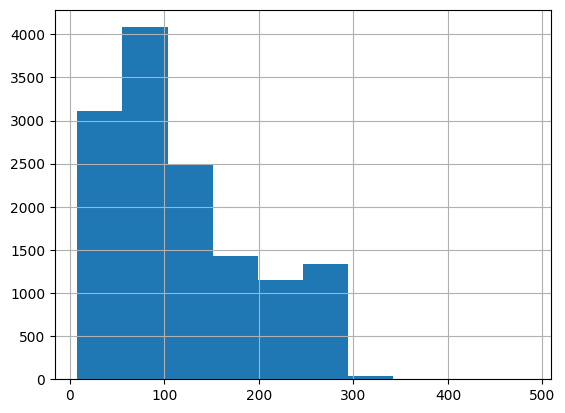

In [ ]:
df_train['text'].str.len().hist() #num caratteri per ogni tweet

<Axes: >

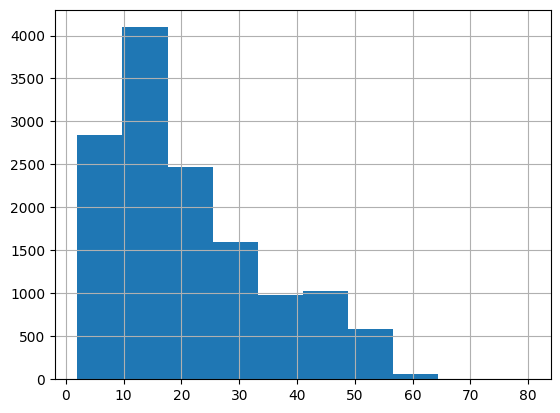

In [ ]:
df_train['text'].str.split().map(lambda x: len(x)).hist() #num parole per ogni frase

In [ ]:
df_train['char_length'] = df_train['text'].str.len()
df_train['n_words'] = df_train.text.str.split().map(lambda x: len(x))

In [ ]:
df_train.sort_values('n_words', ascending=False)

id                                               text  \
1510  1511  stamu piddennu u sennu ni accuggennu unni jenn...   
3506  3507  f atl o bela det na svacàda volti stam sö dos ...   
761    762  miette stu cappiello à maglia cutton scinne ap...   
8322  8323  chiove n ato ppoco stracqua torna chiòvere sch...   
5062  5063  cchest nu nciucio d ajere donna carmela vv agg...   
...    ...                                                ...   
9843  9844                                                pur   
8241  8242                                               cusi   
4577  4578                                               mona   
7302  7303                                               boni   
4576  4577                                               idda   

                     region  n_words  char_length  
1510               Calabria       38          224  
3506         Emilia Romagna       37          165  
761                Campania       36          204  
8322               Campania       35          214  
5062               Campania       35          192  
...                     ...      ...          ...  
9843  Friuli-Venezia Giulia        1            3  
8241              Lombardia        1            4  
4577  Friuli-Venezia Giulia        1            4  
7302                  Lazio        1            4  
4576                Sicilia        1            4  

[13653 rows x 5 columns]

search more strange tweet and symbol

In [ ]:
df_train[df_train['text'].str.contains('aa')]

id                                               text  \
280      281                       spazio pe i telefoni nse faa   
352      353  gl incubi venuto sapere de el parlaa go parlat...   
446      447  scusa colpe i faa solch cassi so tot appesa fi...   
479      480                              maa quantu siì bbonaa   
519      520  siccome lu ga ubidia faa semper feste el vulia...   
586      587  scudetto scucito daacooppaa n avoja arza coppe...   
775      776  chiede so inventati i genitori quarantenati pe...   
897      898  na giornata massacrante de fori callaccia more...   
1222    1223          ciapà sü porta càa ta devet turnaa indrée   
1401    1402  amme piace mortadella maa metto mani palletta ...   
1466    1467  sti pullman ndo vanno fermano allunga braccio ...   
1489    1490      mortacci meo auahahahahahaahahahahahahaahahah   
1837    1838  parla buono so trasformava pezzo merda culpa b...   
2130    2131    coa multa i g ciapà ndaa zinque stee chisà olte   
3049    3050  aa spalletti nn pericoloso fatti gol soli port...   
3243    3244  edet ol dutur diga diabete ghe ona noita sare ...   
3293    3294  tipo i cioè comeback t dato soldi mandare bara...   
3366    3367  commercialisti de cormano n impiccio colle man...   
3450    3451  sento verdone sketch porto d armi t aa data m ...   
3940    3941  taa racconto storia cicerone n imperatore mo n...   
3959    3960  sessista je pare parla de fregna mattina sera ...   
3963    3964  poraccia dicono roma impegnata messo foto sant...   
4266    4267  haa dicevano pazz i pazzi so na lira case edit...   
4371    4372  anco go fato risotin pese el ghe tocaa tete re...   
4447    4448  i vicini terzo palazzo fronte mesta discussion...   
4918    4919  set ol tank belgo l andaa so ure laur mescia t...   
5022    5023            uaau fortunato na accussi quanno capita   
5615    5616  i paradosso gioonda giù pe mura glie c ristaur...   
5720    5721  giugno novembre beh c entra palestre scrivevo ...   
5723    5724  niende bastanu ddu ggiorni gui lu dernano dend...   
5849    5850  coatta ammonisce amo regalo m aavevi ner tacci...   
5987    5988  patente occasioni vista madre o nonna parlava ...   
6458    6459  nient so afesiunat ala cagnulina el de pensa g...   
6680    6681               tii ricorda caa tantu taa cunfissari   
6707    6708  ricordi zelinda parco glie lur i faa pasa chei...   
7435    7436  unito venezia mestre i giudecchini mestrini go...   
7508    7509  rebus daa domenica commenta soluzione fratellì...   
7864    7865              ridere emily taa piji nder culo amica   
7967    7968  manma sky je rode er bucio culo ahhahahaahhaha...   
8025    8026                  mo mme compro aa tuta maggica zzi   
8311    8312    poro possibbile nun c ihai gnent artro faa daje   
8533    8534  ce aa soletta pe scarpe quanno na passeggiata ...   
8632    8633  i paradosso palo gl giornaa ebreo sacco dondol...   
8921    8922  torti arbitraliahahahahahhaahahahahahahahahaha...   
9821    9822  rimbalzare pallone campo iniziare ke tal nn ri...   
9877    9878  cristiano ruiu milan el ciamen cascia bal semp...   
10496  10497       preferisi nebia ch el piöv sti n faa na pell   
10741  10742  go oia de copa so en let beh dorme pio i daa c...   
11236  11237                                  nicò c gnente faa   
11359  11360  stanotte son sognato vando prendevo lucciole m...   
11806  11807  sapevate ok google interprete base lingua sceg...   
12072  12073  i genitori ato aoh nnaamo compiti trascinati p...   
12086  12087  rido mezz storia pallottiahhahahaahhahaahhahah...   
12356  12357     venite siori annoia fiestaa pepepe pepepepe pe   
12468  12469  proposta famo ius soli der cuggino tipo vaccin...   
12862  12863  minuti twitter semo accollati aquila portoghes...   
13345  13346  lur i ria et sai ciciara noed african riga don...   
13349  13350  or the dialect scapaa de ca ovvero fuggiti not...   
13363  13364  paolo inutile ovunque odore nazionalismo ar

In [ ]:
allwords = set(y for x in df_train['text'].str.split() for y in x)

In [ ]:
allwords

{'friulano',
 'acclama',
 'consigliabile',
 'naraza',
 'giuntoli',
 'sadici',
 'sbrigam',
 'atta',
 'credibili',
 'terzo',
 'grati',
 'crocchetta',
 'jenna',
 'avanto',
 'stà',
 'meteme',
 'martenz',
 'stressante',
 'juorno',
 'notte',
 'coretore',
 'imparò',
 'trasporto',
 'cade',
 'beo',
 'manifestano',
 'spezzata',
 'harry',
 'surgelato',
 'menà',
 'burina',
 'bla',
 'fattene',
 'surprise',
 'viti',
 'flavio',
 'vossui',
 'chiappini',
 'crescere',
 'ù',
 'vengano',
 'fœra',
 'leder',
 'canada',
 'mercato',
 'amenta',
 'paolo',
 'farouk',
 'pasto',
 'consoliamo',
 'tembu',
 'dirett',
 'lago',
 'cp',
 'nialtri',
 'paralizzata',
 'strana',
 'silvestri',
 'fanatico',
 'ps',
 'guardò',
 'mavaffangul',
 'affiddandu',
 'circondati',
 'trento',
 'àsempre',
 'cetrioli',
 'snifac',
 'mappazzone',
 'scherzá',
 'antichi',
 'cà',
 'ciûtu',
 'rifonda',
 'talia',
 'bicchieri',
 'london',
 'paragonà',
 'sgozzato',
 'devento',
 'vruaccúl',
 'cessa',
 'francè',
 'sauna',
 'popolari',
 'sciupatino',
 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:50]

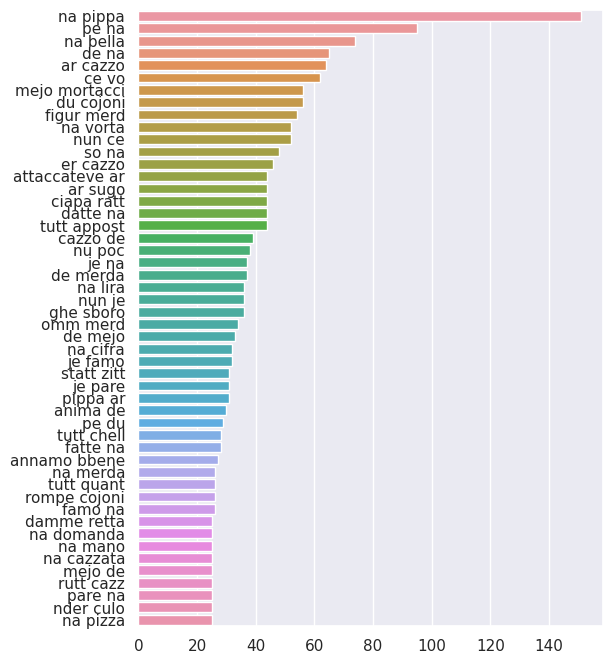

In [ ]:
#get and plot top N-Bigrams

top_n_bigrams = get_top_ngram(df_train['text'],2)[:50]
x, y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)
sns.set(rc={"figure.figsize":(6, 8)}) #width=3, #height=4

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features= 5000)

X_train_tfidf = tfidf.fit_transform(df_train['text']).todense()
print('Train size: ',X_train_tfidf.shape)

Train size:  (13653, 5000)


In [ ]:
tfidf.get_feature_names_out()

array(['aa dato', 'accire nisciun', 'accord milan', ..., 'zitto cojone',
       'zona rossa', 'zu bom'], dtype=object)

In [ ]:
pd.DataFrame(X_train_tfidf, columns=tfidf.get_feature_names_out())

aa  abba  abbasta  abbonamento  abbonati  abbraccio  abita  abito  \
0      0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
1      0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
2      0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
3      0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
4      0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
...    ...   ...      ...          ...       ...        ...    ...    ...   
13648  0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
13649  0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
13650  0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
13651  0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   
13652  0.0   0.0      0.0          0.0       0.0        0.0    0.0    0.0   

       abituati  abraham  abruzzo  accanna  accannate  accanto  accento  \
0           0.0      0.0      0.0      0.0        0.0      0.0      0.0   
1           0.0      0.0      0.0      0.0        0.0      0.0      0.0   
2           0.0      0.0      0.0      0.0        0.0      0.0      0.0   
3           0.0      0.0      0.0      0.0        0.0      0.0      0.0   
4           0.0      0.0      0.0      0.0        0.0      0.0      0.0   
...         ...      ...      ...      ...        ...      ...      ...   
13648       0.0      0.0      0.0      0.0        0.0      0.0      0.0   
13649       0.0      0.0      0.0      0.0        0.0      0.0      0.0   
13650       0.0      0.0      0.0      0.0        0.0      0.0      0.0   
13651       0.0      0.0      0.0      0.0        0.0      0.0      0.0   
13652       0.0      0.0      0.0      0.0        0.0      0.0      0.0   

       accire  accire nisciun  accis  accordo  accorgi  accort  accorta  \
0         0.0             0.0    0.0      0.0      0.0     0.0      0.0   
1         0.0             0.0    0.0      0.0      0.0     0.0      0.0   
2         0.0             0.0    0.0      0.0      0.0     0.0      0.0   
3         0.0             0.0    0.0      0.0      0.0     0.0      0.0   
4         0.0             0.0    0.0      0.0      0.0     0.0      0.0   
...       ...             ...    ...      ...      ...     ...      ...   
13648     0.0             0.0    0.0      0.0      0.0     0.0      0.0   
13649     0.0             0.0    0.0      0.0      0.0     0.0      0.0   
13650     0.0             0.0    0.0      0.0      0.0     0.0      0.0   
13651     0.0             0.0    0.0      0.0      0.0     0.0      0.0   
13652     0.0             0.0    0.0      0.0      0.0     0.0      0.0   

       accorto  account  accussi  accussì  acqua  acquisto  adda  addio  \
0          0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
1          0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
2          0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
3          0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
4          0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
...        ...      ...      ...      ...    ...       ...   ...    ...   
13648      0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
13649      0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
13650      0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
13651      0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   
13652      0.0      0.0      0.0      0.0    0.0       0.0   0.0    0.0   

       addirittura  addo  addore  addosso  addò  ades  adess  adl  adoro   ae  \
0              0.0   0.0     0.0      0.0   0.0   0.0    0.0  0.0    0.0  0.0   
1              0.0   0.0     0.0      0.0   0.0   0.0    0.0  0.0    0.0  0.0   
2              0.0   0.0     0.0      0.0   0.0   0.0    0.0  0.0    0.0  0.0   
3              0.0   0.0     0.0      0.0   0.0   0.0   